In [13]:
import pandas as pd


df = pd.read_csv('train.csv')
df.head()





,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [14]:


# Identifying columns with more than 50% missing values
missing_values = df.isnull().mean()
columns_to_drop = missing_values[missing_values > 0.5].index.tolist()

# Dropping the identified columns and the 'Id' column
df_cleaned = df.drop(columns=columns_to_drop + ['Id'])

# Filling missing values for numerical columns with the median and categorical columns with the mode
numerical_columns = df_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = df_cleaned.select_dtypes(include=['object']).columns.tolist()

for column in numerical_columns:
    df_cleaned[column].fillna(df_cleaned[column].median(), inplace=True)

for column in categorical_columns:
    df_cleaned[column].fillna(df_cleaned[column].mode()[0], inplace=True)


df_cleaned.isnull().sum().max(), df_cleaned.head()



(0,
    MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
 0          60       RL         65.0     8450   Pave      Reg         Lvl   
 1          20       RL         80.0     9600   Pave      Reg         Lvl   
 2          60       RL         68.0    11250   Pave      IR1         Lvl   
 3          70       RL         60.0     9550   Pave      IR1         Lvl   
 4          60       RL         84.0    14260   Pave      IR1         Lvl   
 
   Utilities LotConfig LandSlope  ... EnclosedPorch 3SsnPorch ScreenPorch  \
 0    AllPub    Inside       Gtl  ...             0         0           0   
 1    AllPub       FR2       Gtl  ...             0         0           0   
 2    AllPub    Inside       Gtl  ...             0         0           0   
 3    AllPub    Corner       Gtl  ...           272         0           0   
 4    AllPub       FR2       Gtl  ...             0         0           0   
 
   PoolArea MiscVal  MoSold  YrSold  SaleType  SaleCondition SalePri

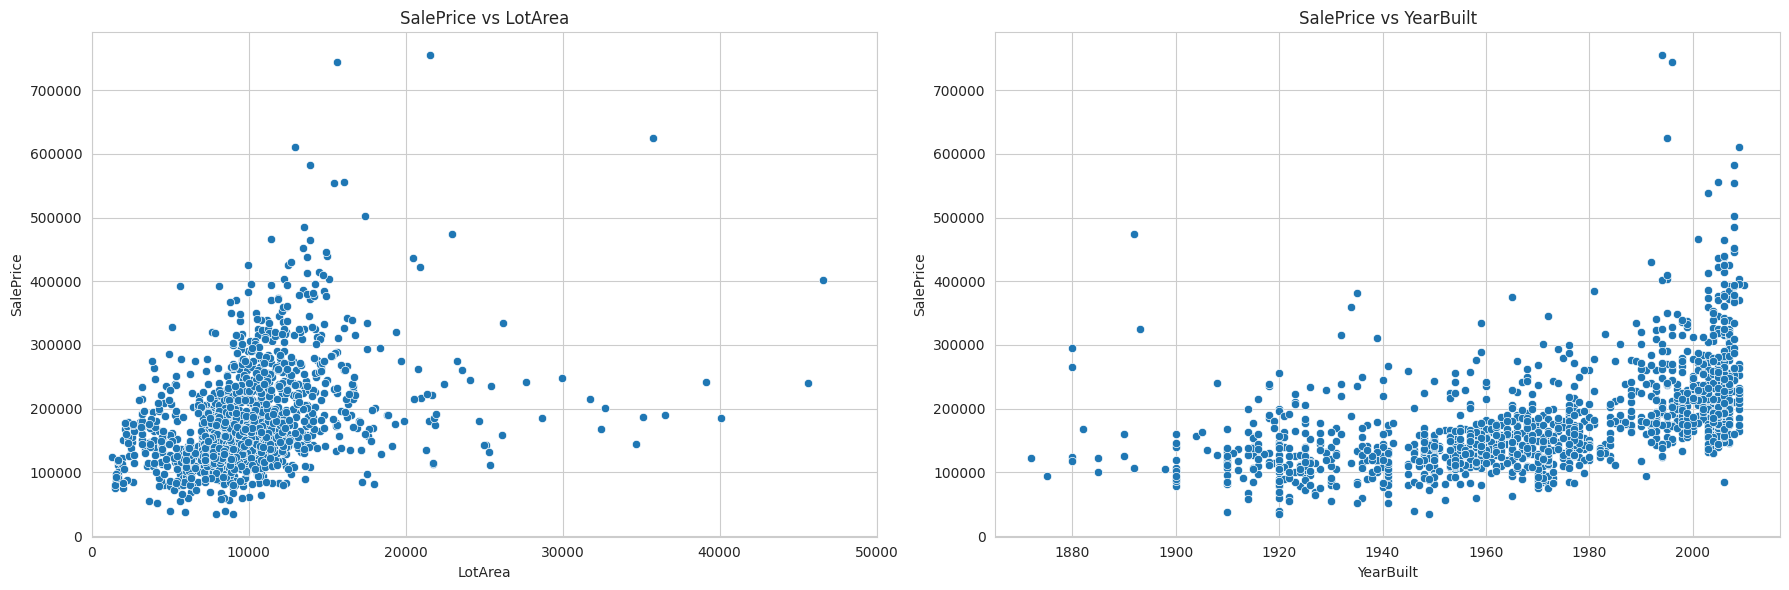

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Relationship between LotArea and SalePrice
sns.scatterplot(ax=axes[0], data=df_cleaned, x='LotArea', y='SalePrice').set_title('SalePrice vs LotArea')

axes[0].set_xlim(0, 50000)

# Relationship between YearBuilt and SalePrice
sns.scatterplot(ax=axes[1], data=df_cleaned, x='YearBuilt', y='SalePrice').set_title('SalePrice vs YearBuilt')

plt.tight_layout()
plt.show()


In [16]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
import numpy as np


features = ['LotArea', 'YearBuilt', 'OverallQual', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars']
target = 'SalePrice'

# Keeping a mix of numerical and categorical features for demonstration
X = df_cleaned[features]
y = df_cleaned[target]

# Encoding categorical variables
categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(exclude=['object']).columns

# Creating a transformer for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying transformations
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


X_train_transformed.shape, X_test_transformed.shape


((1168, 10), (292, 10))

In [17]:
import statsmodels.api as sm


X_train_const = sm.add_constant(X_train_transformed)
X_test_const = sm.add_constant(X_test_transformed)

# Building the OLS model
ols_model = sm.OLS(y_train, X_train_const).fit()


ols_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     381.1
Date:                Wed, 03 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:12:45   Log-Likelihood:                -13952.
No. Observations:                1168   AIC:                         2.793e+04
Df Residuals:                    1157   BIC:                         2.798e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.051e+05   9.97e+04     -8.076      0.000      -1e+06    -6.1e+05
x1             0.6249      0.109      5.740      0.000       0.411       0.839
x2           370.3221     52.174      7.098      0.000     267.955     472.689
x3          2.166e+04   1270.665     17.049      0.000    1.92e+04    2.42e+04
x4            12.8959      4.832      2.669      0.008       3.415      22.377
x5            26.6034     24.167      1.101      0.271     -20.812      74.019
x6            14.5102     23.773      0.610      0.542     -32.133      61.154
x7            31.4398     23.639      1.330      0.184     -14.939      77.819
x8         -5493.1917   2942.654     -1.867      0.062   -1.13e+04     280.344
x9           436.8620   1227.122      0.356      0.722   -1970.771    2844.495
x10         1.415e+04   2019.334      7.008      0.000    1.02e+04    1.81e+04
==============================================================================
Omnibus:                      440.378   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            41176.316
Skew:                          -0.769   Prob(JB):                         0.00
Kurtosis:                      32.047   Cond. No.                     1.39e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
from sklearn.metrics import mean_squared_error, r2_score


y_pred = ols_model.predict(X_test_const)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")



Mean Squared Error: 1556593410.9304435
R^2 Score: 0.7970629450580721


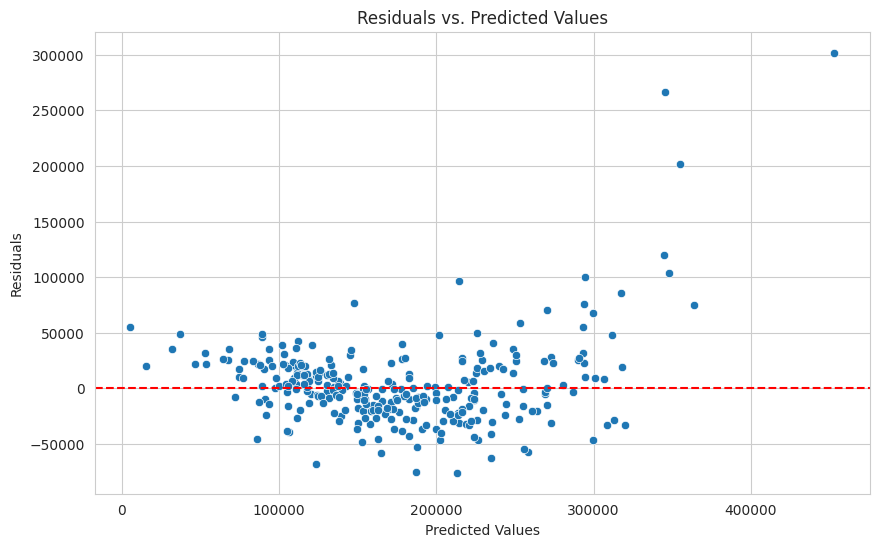

In [20]:


# residuals
residuals = y_test - y_pred


plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()


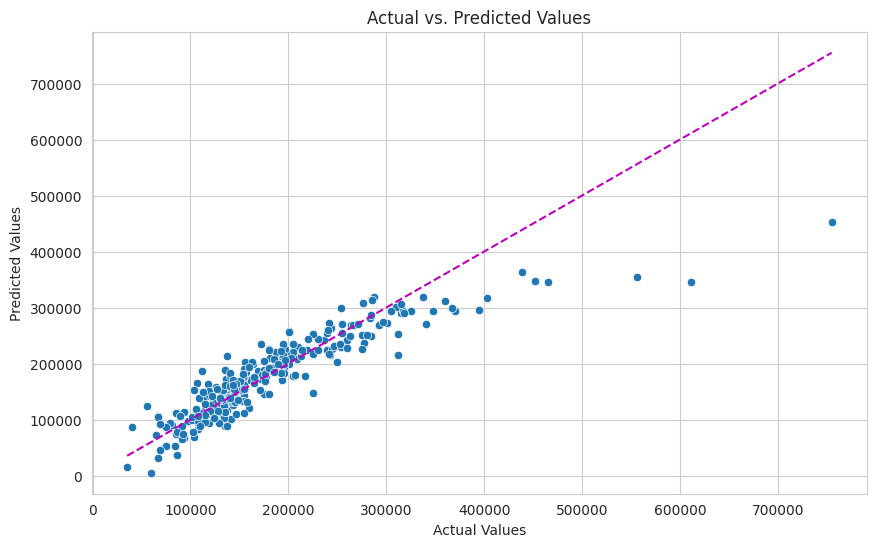

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'm--')
plt.show()


In [23]:

coef_summary = ols_model.summary2().tables[1]
coef_summary.sort_values('Coef.', ascending=False)


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
x3,21663.413235,1270.664513,17.048885,2.566229e-58,1.917035e+04,24156.477922
x10,14151.666761,2019.333717,7.008087,4.094364e-12,1.018970e+04,18113.632749
x9,436.862019,1227.121654,0.356005,7.219014e-01,-1.970771e+03,2844.494901
x2,370.322147,52.174233,7.097798,2.206134e-12,2.679554e+02,472.688850
x7,31.439785,23.638523,1.330023,1.837727e-01,-1.493939e+01,77.818957
x5,26.603434,24.166853,1.100823,2.712025e-01,-2.081233e+01,74.019197
x6,14.510235,23.773174,0.610362,5.417421e-01,-3.213312e+01,61.153594
x4,12.895853,4.832330,2.668662,7.721912e-03,3.414742e+00,22.376963
x1,0.624905,0.108876,5.739589,1.211332e-08,4.112883e-01,0.838523
x8,-5493.191704,2942.654214,-1.866747,6.218967e-02,-1.126673e+04,280.344296


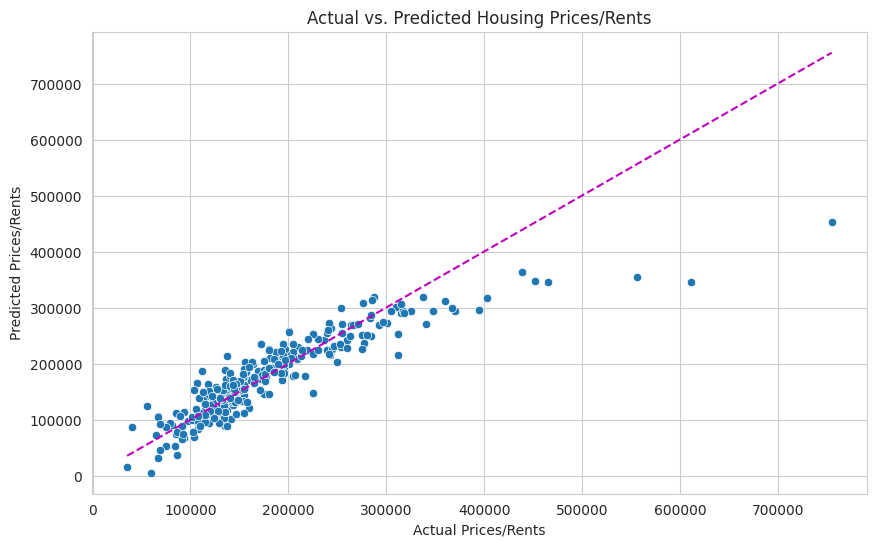

In [24]:
#Scatter Plot of Actual vs. Predicted Values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.title('Actual vs. Predicted Housing Prices/Rents')
plt.xlabel('Actual Prices/Rents')
plt.ylabel('Predicted Prices/Rents')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'm--')
plt.show()


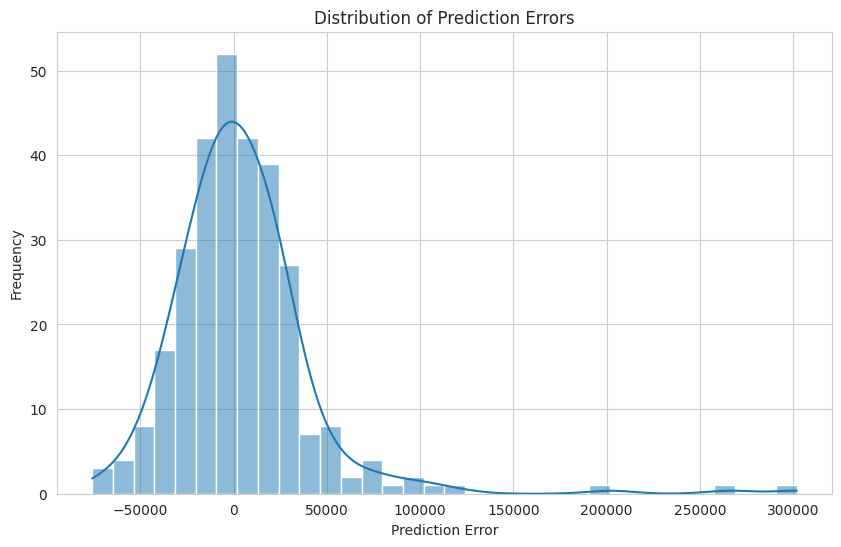

In [25]:
# Distribution Plot of Prediction Errors 

errors = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()


In [30]:

# estimated monthly rent as 0.5% of SalePrice
estimated_rent = y_pred * 0.005
print(estimated_rent)


[ 720.0500743  1465.1364687   600.457951    854.74872936 1450.90538602
  266.36181833 1072.59741774  837.24508349  264.0490115   673.5964235
  799.11645203  554.44319025  453.58548227 1120.31207963  959.88359138
  574.10587699 1071.11855754  617.7548728   620.67638231 1099.62521118
  881.14876251 1149.24471535  897.06510217  540.20859233 1069.53632079
  862.12086368 1051.70323481  509.31621751  942.04264481 1037.3352404
  573.92541942 1244.77270191  995.69938868  445.71229452 1351.82631458
  748.72446188  791.8433854  1119.97641568 1502.92366134  485.53735269
  698.10767033 1176.4382695   587.28720962 1497.88383387  653.5921463
  813.64952567  554.72968641  575.68789582 1740.04181013  694.92110943
  548.85189968  969.04394801  589.10180092 1598.64087583  772.48004204
 1198.5142467  1070.32914159  724.58780075  825.30646476  452.71701766
  232.06633002  665.18683447 1469.63155548 1346.32488453 1402.94026931
 1080.13803848  523.49787738 1472.13279634  565.05457817  859.4449875
  751.9053

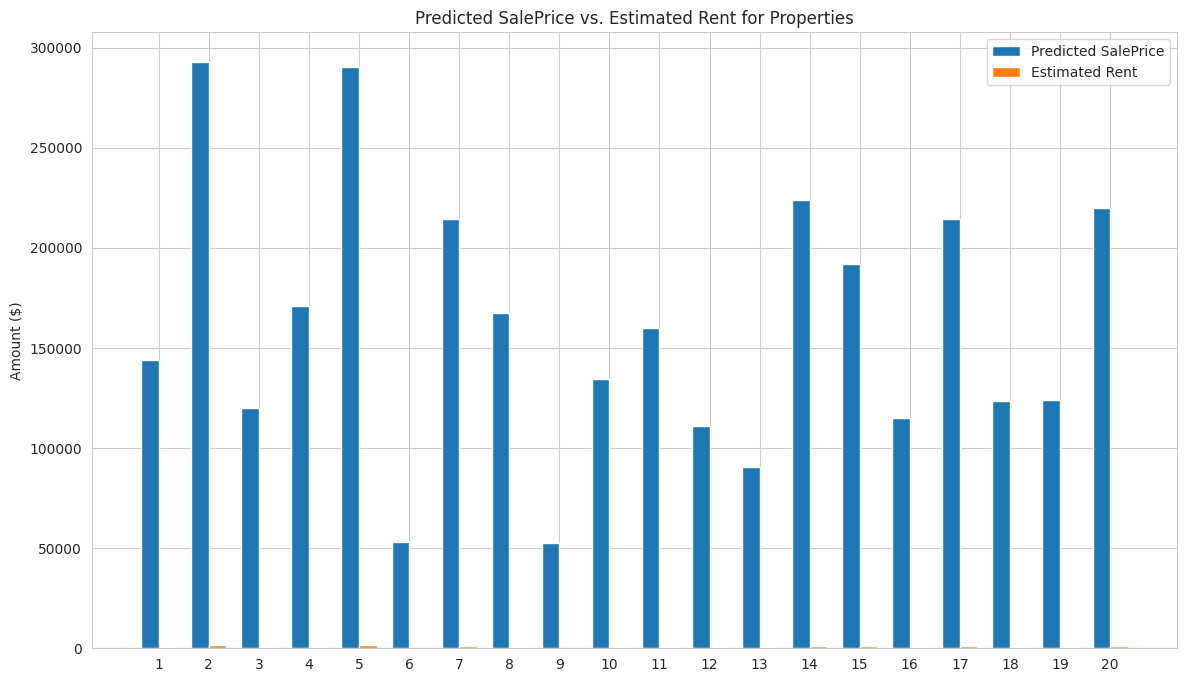

In [31]:

indices = np.arange(20)  # Adjust the number for more or fewer entries

#  SalePrice and Rent for comparison
plt.figure(figsize=(14, 8))


width = 0.35

# SalePrice predictions
plt.bar(indices - width/2, y_pred[:20], width, label='Predicted SalePrice')

# estimated Rent
plt.bar(indices + width/2, estimated_rent[:20], width, label='Estimated Rent')

plt.ylabel('Amount ($)')
plt.title('Predicted SalePrice vs. Estimated Rent for Properties')
plt.xticks(indices, labels=np.arange(1, 21), rotation='horizontal')
plt.legend()


plt.show()
